# Implementing Ordinary Least Squares Linear Regression (with 2 dimensions)

Linear regression is an approach to modeling where the prediction is a linear combination some model parameters and the input variables.

A popular way of generating (or estimating) the linear regression model is the Least Squares method. This method trains a model by finding the model that best reduces the square of the error between our training data and what our model would predict for the input variables of the training data. 

It is possible to weight the errors when we apply this method. If we do not apply weights to the errors then we have what is called the Ordinary Least Squares method. In this circumstance there is a close form calculation we can use to find the parameters using linear algebra techniques. This closed form calculation is often called Ordinary Least Squares:



When there are only two dimensions (one independent one dependent) then the model will have two parameters and the method for solving for those parameters reduces to:

m = covariance(x, y) / variance (x)

c = mean(y) - m * mean(x)

The two dimensional variant of the closed form calculation of Ordinary Least Squares is called Simple Linear Regression.

When the close form solution of this problem is too computationaly expensive then we can use a gradient descent algorithm to solve for the parameters that minimizes the Ordinary Least Squares error. 

Reference for Dataset: Swedish Committee on Analysis of Risk Premium in Motor Insurance

Thanks to machinelearningmaster.com and oreilly online learning for educational resources

## Simple Linear Regression

Following https://machinelearningmastery.com/implement-simple-linear-regression-scratch-python/ I implement simple linear regression.

In [26]:
# Import Libraries
from random import seed
from random import randrange
from csv import reader
from math import sqrt

from matplotlib import pyplot as plt
%matplotlib inline

In [220]:
# Import Data
dataset = list()
with open('swedishinsurance.csv', 'r', encoding='utf-8-sig') as file:
    csv_reader = reader(file)
    for row in csv_reader:
        if not row: 
            continue
        row = (float(row[0]), float(row[1]))
        dataset.append(row)
# Check dataset
dataset[:5]

[(108.0, 392.5), (19.0, 46.2), (13.0, 15.7), (124.0, 422.2), (40.0, 119.4)]

In [221]:
# Splitting dataset into training and testing data with test size being 40% of data
seed(1)
test = []
test_size = .33 * len(dataset)
train = list(dataset)
while len(test) < test_size:
    rand_index = randrange(len(train))
    test.append(train.pop(rand_index))
print(len(dataset), len(train), len(test))

63 42 21


In [222]:
#splitting train and test data into input and target vectors
x_train = [row[0] for row in train]
y_train = [row[1] for row in train]

x_test = [row[0] for row in test]
y_test = [row[1] for row in test]

In [71]:
def mean(values):
    return sum(values) / float(len(values))

In [72]:
def variance(values, mean):
    return sum([(x-mean)**2 for x in values])

In [73]:
def covariance(x, mean_x, y, mean_y):
    covar = 0.0
    for i in range(len(x)):
        covar += (x[i] - mean_x) * (y[i] - mean_y)
    return covar

In [74]:
# Using covariance and variance to estimate a linear 2 dimensional model

# Calculating mean of x and y, variance of x and covariance of x, y
mean_x, mean_y = mean(x_train), mean(y_train)
var_x = variance(x_train, mean_x)
covar_xy = covariance(x_train, mean_x, y_train, mean_y)

# Calculating parameters of 2-d linear regression model
m = covar_xy/var_x
c = mean(y_train) - m * (mean_x)

print(f'm = {m:.2f}, c={c:.2f}')

m = 3.39, c=16.57


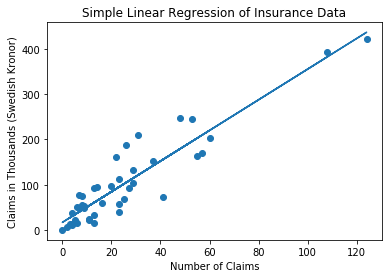

In [223]:
# plotting scatter plot of training data and graph
plt.scatter(x_train, y_train)
plt.plot(x_train, [m * x + c for x in x_train])
plt.xlabel('Number of Claims')
plt.ylabel('Claims in Thousands (Swedish Kronor)')
plt.title('Simple Linear Regression of Insurance Data')
plt.show()

In [76]:
# make predictions on test data
predictions = [m*x+c for x in x_test]

In [77]:
# evaluating predictions using root mean squared error
def calc_rmse(actuals, predictions):
    sum_square_errors = 0.0
    for i in range(len(predictions)):
        prediction_error = predictions[i] - actuals[i]
        sum_square_errors += prediction_error**2
    mse = sum_square_errors / float(len(predictions))
    return sqrt(mse)
rmse = calc_rmse(y_test, predictions)
print(f'RMSE: {rmse:.3f} thousands of Kronor')

RMSE: 33.711 thousands of Kronor


## Estimating Ordinary Least Squares Model using Gradient Descent Method

Following https://learning.oreilly.com/library/view/python-machine-learning/9781783555130/ch10s03.html

This implementation applies to inputs with multiple variables and thus uses linear algebra. We could also perform an implementation that utilized partial derivatives to calculate the Gradient Descent. In this case we will use Stochastic Gradient Descent which is more approximate but also more general.

In [79]:
import numpy as np
from collections import defaultdict

In [341]:
# requires that X has a 1 all down its first column
# This algorithm is very sensitive to the learning rate 
# Attempted to account for this by scaling it with the max of the y values

class LinearRegressionSGD(object):
    
    def __init__(self, standard_eta=0.01, n_iter=20):
        self.stdeta = standard_eta
        self.n_iter = n_iter
    
    def fit(self, X_train, y_train):
        self.coef_ = np.zeros(X_train.shape[1])
        self.iterations_ = defaultdict(dict)
        
        for i in range(self.n_iter):
            predicted = self.predict(X_train)
            errors = (predicted - y_train)
            self.iterations_[i]['coef'] = (self.coef_[0], self.coef_[1])
            delta_coef = -self.stdeta/max(y_train) * X_train.T.dot(errors)
            self.coef_ += delta_coef
            cost = (errors**2).sum()
            self.iterations_[i]['cost'] = cost
        return self
    
    def fitted_model(self):
        return self.iterations_[self.n_iter-1]
    
    def predict(self, X):
        return np.dot(X, self.coef_)

In [231]:
X_train = np.asarray([[1, x] for x in x_train])
X_test = np.asarray([[1, x] for x in x_test])
X_train.shape

(42, 2)

In [342]:
lr = LinearRegressionSGD()
lr.n_iter=10
lr.fit(X_train, y_train)
lr.fitted_model()

{'coef': (0.1489187247362218, 3.706856496264331), 'cost': 61899.13426903996}

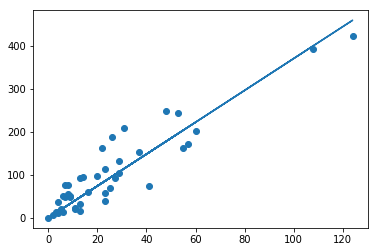

In [343]:
plt.scatter([x[1] for x in X_train], y_train)
plt.plot([x[1] for x in X_train], lr.predict(X_train))

In [287]:
# make predictions on test data
predictions = lr.predict(X_test)

In [315]:
# evaluating predictions using root mean squared error
def calc_rmse(actuals, predictions):
    sum_square_errors = 0.0
    for i in range(len(predictions)):
        prediction_error = predictions[i] - actuals[i]
        sum_square_errors += prediction_error**2
    mse = sum_square_errors / float(len(predictions))
    return sqrt(mse)
rmse = calc_rmse(y_test, predictions)
print(f'RMSE: {rmse:.3f} thousands of Kronor')

RMSE: 38.181 thousands of Kronor


In [289]:
# plotting the decrease in our cost function over iterations
def plot_cost_v_epochs(lr):
    plt.plot(range(1, lr.n_iter+1), [data['cost'] for epoch, data in lr.iterations_.items()])
    plt.ylabel('SSE')
    plt.xlabel('Epoch')
    plt.title('SSE vs. Epochs')
    plt.show

In [339]:
def plot_2d_iterations(lr, X, y):
    n_iter = lr.n_iter
    step_size = int(n_iter/3)
    steps = [n_iter-i*step_size-1 for i in range(3)]
    steps.extend([2,1,0])
    steps.reverse()
    for i in steps:
        c = lr.iterations_[i]['coef'][0]
        m = lr.iterations_[i]['coef'][1]
        cost = lr.iterations_[i]['cost']
        plt.scatter([x[1] for x in X], y)
        plt.plot([x[1] for x in X], [m*x[1]+c for x in X])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'Graph for {i+1} iteration, SSE: {cost:.1f}')
        plt.show()

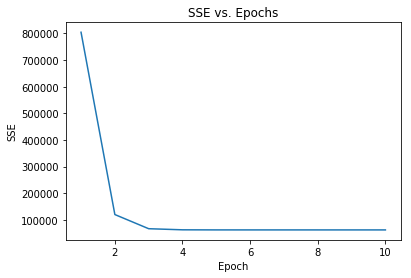

In [344]:
plot_cost_v_epochs(lr)

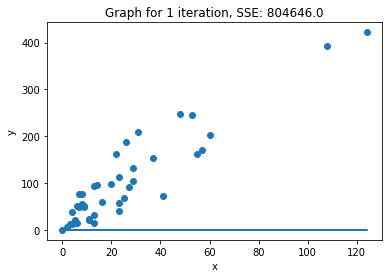

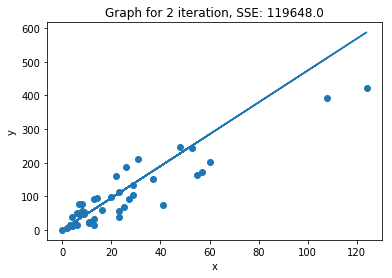

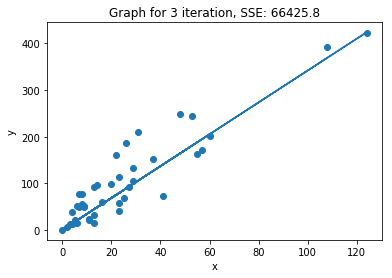

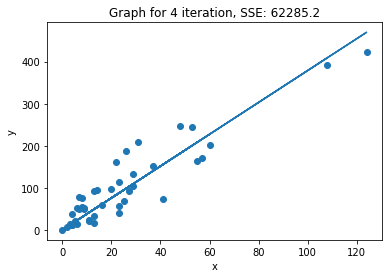

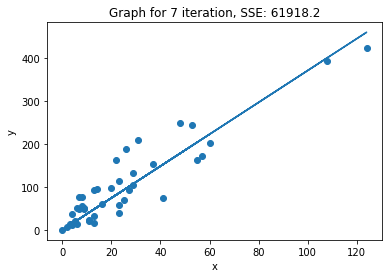

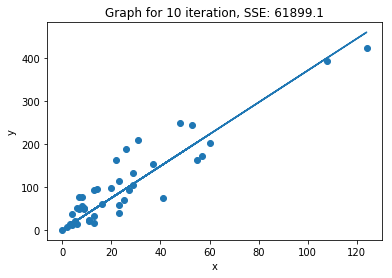

In [345]:
plot_2d_iterations(lr, X_train, y_train)

We can see that within 3 iterations we have almost reached the minimum of the cost function.

In [227]:
# Experimenting with Stochastic Gradient Descent on toy dataset
toy_data = dataset = [[1, 1], [2, 3], [4, 3], [3, 2], [5, 5]]

In [228]:
toy_x = [row[0] for row in dataset]
toy_y = [row[1] for row in dataset]
toy_X = np.asarray([(1, x) for x in toy_x])

In [265]:
lr = LinearRegressionSGD()
lr.fit(toy_X, toy_y)
lr.fitted_model()

{'cost': 2.4213693720663207, 'coef': array([0.24730859, 0.84061339])}

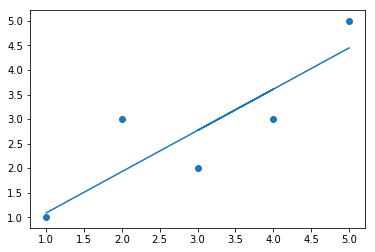

In [263]:
plt.scatter(toy_x, toy_y)
plt.plot(toy_x, lr.predict(toy_X))